In [ ]:
!pip install hazm

In [ ]:
from hazm import Normalizer
import re
import json
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from hazm import stopwords_list

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/PerCQA_JSON_Format.json", 'r', encoding='utf-8-sig') as f:
    data = json.load(f)

questions = []
answers = []

for entry in data:
    # Question fields
    q_id = entry.get('QID')
    q_body = entry.get('QBody')
    q_user = entry.get('QUsername')
    q_date = entry.get('QDATE')
    q_subject = entry.get('QSubject')

    questions.append({
        'QID': q_id,
        'QBody': q_body,
        'QUsername': q_user,
        'QDate': q_date,
        'QSubject' : q_subject
    })

    # Comments/answers
    for c in entry.get('Comments', []):
        answers.append({
            'QID': q_id,
            'CID': c.get('CID'),
            'CBody': c.get('CBody'),
            'CUsername': c.get('CUsername'),
            'CDate': c.get('CDate'),
            'LabelDate': c.get('LabelDate')
        })

questions_df = pd.DataFrame(questions)
answers_df = pd.DataFrame(answers)

print(" Sample questions:")
questions_df.head()


 Sample questions:


,QID,QBody,QUsername,QDate,QSubject
0,1550088,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه ...,sami1366,2018-01-01T12:14:00,قهر شوهرم
1,1558609,من خودم حس میکنم اشتباهم گیر دادن بیخودی و غر ...,khanoomi72,2018-01-06T00:17:00,بزرگترین اشتباه دوران نامزدیتون چی بوده؟؟
2,1587820,سالگرد ازدواجم نزدیکه چی بخرم. سالگرد دوممونه....,lol,2018-01-22T13:23:00,کمک سالگرد ازدواجم نزدیکه
3,4414921,دختر من چهارده ماهه است. آیا برای تشخیص پرانتز...,sepide1400,2020-05-23T02:06:00,متخصص ارتوپدی برای درمان پرانتزی پا
4,3109668,چه پمادی بزنم و از چیه اینجور شده . واضح نیس...,نسا۷۹,2019-08-13T12:07:00,لپ پسرم قرمز دون دونه


In [ ]:
print("\n Sample answers:")
answers_df.head()


 Sample answers:


,QID,CID,CBody,CUsername,CDate,LabelDate
0,1550088,50758322,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,mahboub,None,2020-04-28T23:57:28.9458377
1,1550088,50758362,انقدر تحويلش نگير تا خودش بياد سمتت،اين جوري ا...,eshghiii,None,2020-04-29T00:32:46.1344058
2,1550088,50758382,تولد براش بگير. قهر جداس,44,None,2020-04-29T00:32:48.054768
3,1550088,50758410,تولدشون رو تبریک بگین . جوری که احساس نکنن دار...,golsa82,None,2020-04-29T00:43:34.305984
4,1550088,50758416,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,بهاران_عشق,None,2020-04-29T00:43:41.4450752


### Full Text Normalization Pipeline for Persian (with Bonus Features)

This function cleans and standardizes Persian text in several stages, ensuring it's ready for NLP tasks like embedding, classification, or search.

---

#### Steps Performed:

1. **Hazm Normalization**  
   Standardizes spacing, half-spaces, and common orthographic issues in Persian text.

2. **Arabic → Persian Character Fixes**  
   Manually replaces Arabic characters with correct Persian equivalents using a custom mapping dictionary.

3. **Slang Replacement**
   Informal or emotional expressions like `"خخخ"`, `"عههه"`, `"اوووه"` are replaced with standardized terms like `"خنده"` or `"تعجب"` using regex.

4. **Character Repetition Normalization**  
   Repeated characters for emphasis (e.g., `"عااااااالی"`) are reduced to one character.


5. **Punctuation and Extra Whitespace Removal**
   Removes non-Persian symbols and redundant spaces for clean tokenization.

6. **Diacritic Removal**
   Strips vowel marks and other Arabic diacritics (e.g., "َ", "ً", "ِ", "ّ") using a Unicode regex.

In [ ]:
normalizer = Normalizer()

# Define diacritics
persian_diacritics = re.compile(r'[\u064B-\u0652\u0670\u06D6-\u06ED]')

arabic_to_persian = {
    'ي': 'ی',
    'ك': 'ک',
    'ۀ': 'ه',
    'ؤ': 'و',
    'إ': 'ا',
    'أ': 'ا',
    'ة': 'ه',
    'ى': 'ی',
}


punctuations = set(string.punctuation).union(set([".", "|", "؟", "،", "«", '»', "!", "<", ">", ")", "(", ":", "؛",
                                                  "#", "$", "%", "^", "&", "*", "[", "]", "}", "{", "_", "-", "/",
                                                  "+", "'", "۱", "۲", "۳", "۴", "۵", "۶", "۷", "۸", "۹", "۰"]))

def normalize_and_remove_diacritics(text):

    if not isinstance(text, str):
        return ""

    text = normalizer.normalize(text)

    text = ''.join([char for char in text if char not in punctuations])

    # Manually fix Arabic to Persian letters (if hazm missed any)
    for arabic_char, persian_char in arabic_to_persian.items():
        text = text.replace(arabic_char, persian_char)


    text = re.sub(r'[^\w\s\u0600-\u06FF]', ' ', text)  # keep only Persian/Arabic chars and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces, one or more whitespace characters (spaces, tabs, newlines)
    text = re.sub(r'(.)\1{1,}', r'\1', text) # Normalize character repetition
    text = re.sub(r'https?://\S+', '', text)  # Remove URLs

    # Remove diacritics using regex
    text = persian_diacritics.sub('', text)

    return text

questions_df["QBody_clean"] = questions_df["QBody"].apply(normalize_and_remove_diacritics)
answers_df["CBody_clean"] = answers_df["CBody"].apply(normalize_and_remove_diacritics)

print(normalize_and_remove_diacritics("عااااالیییییی مُحَمَّد"))
print(normalize_and_remove_diacritics(".سلام! این‌جا (آزمون) شماره: ۱۲۳۴ است ؟ بله"))

عالی محمد
سلام این جا آزمون شماره است بله


## Tokenizing

In [ ]:
from hazm import WordTokenizer

tokenizer = WordTokenizer()

slang_token_map = {
    r'خ': 'خنده',
    r'ه': 'خنده',
    r'عه': 'تعجب',
    r'اوه': 'تعجب',
}


questions_df["QBody_tokens"] = questions_df["QBody_clean"].apply(
    lambda text: [
        slang_token_map.get(t, t)  # replace slang if in map
        for t in tokenizer.tokenize(text)
        if t.lower() != "nbsp"
    ]
)

questions_df["QBody_tokens"] = questions_df["QBody_tokens"].apply(
    lambda tokens: [t for t in tokens if t.strip() != ""]
)

answers_df["CBody_tokens"] = answers_df["CBody_clean"].apply(
    lambda text: [
        slang_token_map.get(t, t)
        for t in tokenizer.tokenize(text)
        if t.lower() != "nbsp"
    ]
)

answers_df["CBody_tokens"] = answers_df["CBody_tokens"].apply(
    lambda tokens: [t for t in tokens if t.strip() != ""]
)

sum_differences_tokens = 0
for i in range(len(questions_df)):
    sum_differences_tokens += len(questions_df["QBody_tokens"].iloc[i]) - len(questions_df["QBody_clean"].iloc[i].split())

print(sum_differences_tokens)

print("Original:", questions_df["QBody_clean"].iloc[0], len(questions_df["QBody_clean"].iloc[0].split()))
print("Tokens  :", questions_df["QBody_tokens"].iloc[0], len(questions_df["QBody_tokens"].iloc[0]))

-85
Original: دوستان نامزدم شوهرم باهام قهره امروز تولدشه چه کنم موضوع دعوامون چیزی بوده که من مقصرش نیستم خودشم میدونه ربطی به من نداره 23
Tokens  : ['دوستان', 'نامزدم', 'شوهرم', 'باهام', 'قهره', 'امروز', 'تولدشه', 'چه', 'کنم', 'موضوع', 'دعوامون', 'چیزی', 'بوده', 'که', 'من', 'مقصرش', 'نیستم', 'خودشم', 'میدونه', 'ربطی', 'به', 'من', 'نداره'] 23


## Remove Stopwords

In [ ]:
from hazm import stopwords_list

stopwords = set(stopwords_list())

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords and word.strip() != '']

questions_df["QBody_tokens_nostop"] = questions_df["QBody_tokens"].apply(remove_stopwords)
answers_df["CBody_tokens_nostop"] = answers_df["CBody_tokens"].apply(remove_stopwords)

print("Before:", questions_df["QBody_tokens"].iloc[0])
print("After :", questions_df["QBody_tokens_nostop"].iloc[0])

Before: ['دوستان', 'نامزدم', 'شوهرم', 'باهام', 'قهره', 'امروز', 'تولدشه', 'چه', 'کنم', 'موضوع', 'دعوامون', 'چیزی', 'بوده', 'که', 'من', 'مقصرش', 'نیستم', 'خودشم', 'میدونه', 'ربطی', 'به', 'من', 'نداره']
After : ['دوستان', 'نامزدم', 'شوهرم', 'باهام', 'قهره', 'امروز', 'تولدشه', 'موضوع', 'دعوامون', 'مقصرش', 'نیستم', 'خودشم', 'میدونه', 'ربطی', 'نداره']


### Stemming vs. Lemmatization in Persian NLP

| Feature       | **Stemming**                                 | **Lemmatization**                              |
|---------------|----------------------------------------------|------------------------------------------------|
| **Speed**     |  Faster (rule-based suffix cutting)        |  Slower (requires dictionary lookup)        |
| **Accuracy**  |  Lower (may cut too much or too little)     |  Higher (returns actual dictionary word forms) |
| **Output**    | Root-like (may not be a real word)           | Valid Persian word (e.g., "گفتن")               |

---

###  We use Lemmatization

- Groups different forms of the same verb (e.g., "گفت", "می‌گوید", "گفتند") → "گفتن"
- Improves the **quality of text embeddings**
- Reduces **vocabulary noise**



In [ ]:
from hazm import Stemmer, Lemmatizer

stemmer = Stemmer()
lemmatizer = Lemmatizer()

def stem_tokens(tokens):
    return [stemmer.stem(word) for word in tokens]

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word).split('#')[0] for word in tokens]


print(stem_tokens(questions_df["QBody_tokens_nostop"].iloc[0]))
print(lemmatize_tokens(questions_df["QBody_tokens_nostop"].iloc[0]))

questions_df["QBody_lemmas"] = questions_df["QBody_tokens_nostop"].apply(lemmatize_tokens)
answers_df["CBody_lemmas"] = answers_df["CBody_tokens_nostop"].apply(lemmatize_tokens)


['دوس', 'نامزد', 'شوهر', 'با', 'قهره', 'امروز', 'تولدشه', 'موضوع', 'دعوامون', 'مقصر', 'نیس', 'خود', 'میدونه', 'ربط', 'نداره']
['دوستان', 'نامزد', 'شوهر', 'با', 'قهره', 'امروز', 'تولدشه', 'موضوع', 'دعوامون', 'مقصر', 'نیستم', 'خود', 'میدونه', 'ربطی', 'نداره']


## Displaying Persian Text Correctly

In [ ]:
!pip install arabic_reshaper
!pip install python-bidi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 5.0 MB/s eta 0:00:00


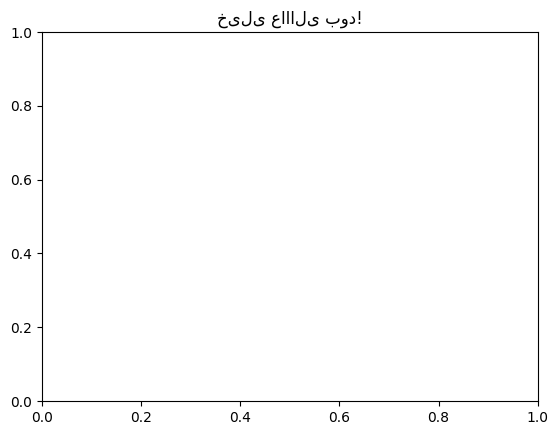

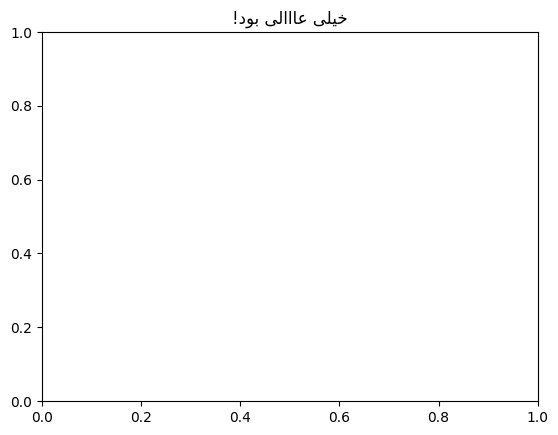

In [ ]:
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.pyplot as plt

def display_persian(text):
    if isinstance(text, str):
        reshaped_text = arabic_reshaper.reshape(text)
        bidi_text = get_display(reshaped_text)
        return bidi_text
    return text

def display_persian_list(tokens):
    if isinstance(tokens, list):
        return [get_display(arabic_reshaper.reshape(tok)) for tok in tokens]
    return tokens


text = "خیلی عااالی بود!"
plt.title(text)
plt.show()

fixed_text = display_persian(text)
plt.title(fixed_text)
plt.show()


In [ ]:
questions_df["QBody_lemmas_persian_display"] = questions_df["QBody_lemmas"].apply(display_persian_list)
answers_df["CBody_lemmas_persian_display"] = answers_df["CBody_lemmas"].apply(display_persian_list)

questions_df["QBody_clean_persian_display"] = questions_df["QBody_clean"].apply(display_persian)
answers_df["CBody_clean_persian_display"] = answers_df["CBody_clean"].apply(display_persian)

answers_df.head()

,QID,CID,CBody,CUsername,CDate,LabelDate,CBody_clean,CBody_tokens,CBody_tokens_nostop,CBody_lemmas,CBody_lemmas_persian_display,CBody_clean_persian_display
0,1550088,50758322,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,mahboub,None,2020-04-28T23:57:28.9458377,قهر جدا تولد جدا ضمنا خواهرانه میگم این قهر و ...,"[قهر, جدا, تولد, جدا, ضمنا, خواهرانه, میگم, ای...","[قهر, جدا, تولد, جدا, ضمنا, خواهرانه, میگم, قه...","[قهر, جدا, تولد, جدا, ضمنا, خواهرانه, میگ, قهر...","[ﺮﻬﻗ, ﺍﺪﺟ, ﺪﻟﻮﺗ, ﺍﺪﺟ, ﺎﻨﻤﺿ, ﻪﻧﺍﺮﻫﺍﻮﺧ, ﮓﯿﻣ, ﺮﻬﻗ...",ﻡﺰﯾﺰﻋ ﻦﮐ ﺵﻮﺤﻣ ﺖﯿﮔﺪﻧﺯ ﯼﺍﺪﺘﺑﺍ ﻦﯿﻤﻫ ﻭ ﺮﻬﻗ ﻦﯾﺍ ﻢﮕﯿ...
1,1550088,50758362,انقدر تحويلش نگير تا خودش بياد سمتت،اين جوري ا...,eshghiii,None,2020-04-29T00:32:46.1344058,انقدر تحویلش نگیر تا خودش بیاد سمت این جوری اد...,"[انقدر, تحویلش, نگیر, تا, خودش, بیاد, سمت, این...","[انقدر, تحویلش, نگیر, بیاد, جوری, ادب, شه, دیگ...","[انقدر, تحویل, نگیر, بیاد, جوری, ادب, شه, دیگه...","[ﺭﺪﻘﻧﺍ, ﻞﯾﻮﺤﺗ, ﺮﯿﮕﻧ, ﺩﺎﯿﺑ, ﯼﺭﻮﺟ, ﺏﺩﺍ, ﻪﺷ, ﻪﮕﯾﺩ...",ﻡﺰﯾﺰﻋ ﺮﺘﻬﺑ ﯼﺪﺑ ﻡﺎﺠﻧﺍ ﻭﺭ ﻢﺘﻔﮔ ﻪﮐ ﯼﺭﺎﮑﻨﯾﺍ ﯽﻧﺰﻧ ﮓ...
2,1550088,50758382,تولد براش بگير. قهر جداس,44,None,2020-04-29T00:32:48.054768,تولد براش بگیر قهر جداس,"[تولد, براش, بگیر, قهر, جداس]","[تولد, براش, بگیر, قهر, جداس]","[تولد, براش, بگیر, قهر, جداس]","[ﺪﻟﻮﺗ, ﺵﺍﺮﺑ, ﺮﯿﮕﺑ, ﺮﻬﻗ, ﺱﺍﺪﺟ]",ﺱﺍﺪﺟ ﺮﻬﻗ ﺮﯿﮕﺑ ﺵﺍﺮﺑ ﺪﻟﻮﺗ
3,1550088,50758410,تولدشون رو تبریک بگین . جوری که احساس نکنن دار...,golsa82,None,2020-04-29T00:43:34.305984,تولدشون رو تبریک بگین جوری که احساس نکن دارین ...,"[تولدشون, رو, تبریک, بگین, جوری, که, احساس, نک...","[تولدشون, تبریک, بگین, جوری, احساس, نکن, دارین...","[تولدشون, تبریک, بگین, جوری, احساس, نکن, دارین...","[ﻥﻮﺷﺪﻟﻮﺗ, ﮏﯾﺮﺒﺗ, ﻦﯿﮕﺑ, ﯼﺭﻮﺟ, ﺱﺎﺴﺣﺍ, ﻦﮑﻧ, ﻦﯾﺭﺍﺩ...",ﻦﺷﺎﺑ ﻪﺘﺷﺍﺪﻧ ﻦﺘﻔﮔ ﺍﺮﺑ ﻑﺮﺣ ﺍﺪﻌﺑ ﺎﺗ ﻦﯿﮕﺑ ﮏﯾﺮﺒﺗ ﻢﮕ...
4,1550088,50758416,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,بهاران_عشق,None,2020-04-29T00:43:41.4450752,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,"[تو, کادوت, رو, بخر, و, آماده, بزار, تا, شب, ا...","[کادوت, بخر, آماده, بزار, شب, اگه, زنگت, نزد, ...","[کادو, بخر, آماده, بزار, شب, اگه, زنگت, نزد, خ...","[ﻭﺩﺎﮐ, ﺮﺨﺑ, ﻩﺩﺎﻣﺁ, ﺭﺍﺰﺑ, ﺐﺷ, ﻪﮔﺍ, ﺖﮕﻧﺯ, ﺩﺰﻧ, ﺕ...",ﻮﻤﯿﻟ ﺮﺘﺴﻟﺩ ﻭ ﻩﺩﺭﻭﺮﭘ ﻥﻮﺘﯾﺯ ﻭ ﺮﯿﺳﻮﻣ ﺖﺳﺎﻣ ﻭ ﻞﺼﻓ ﺩ...


## Display 2 samples

In [ ]:
for i in range(2):
    print(f"\n Question {i+1}:")
    print(questions_df.loc[i, "QBody_lemmas"])
    print(f"\n Answer {i + 1}:")
    print(answers_df.loc[i, "CBody_lemmas"])


 Question 1:
['دوستان', 'نامزد', 'شوهر', 'با', 'قهره', 'امروز', 'تولدشه', 'موضوع', 'دعوامون', 'مقصر', 'نیستم', 'خود', 'میدونه', 'ربطی', 'نداره']

 Answer 1:
['قهر', 'جدا', 'تولد', 'جدا', 'ضمنا', 'خواهرانه', 'میگ', 'قهر', 'ابتدا', 'زندگیت', 'محو', 'کن', 'عزیز']

 Question 2:
['خودم', 'حس', 'اشتباه', 'گیر', 'بیخودی', 'غر', 'زدن', 'های', 'زیادمه', 'اشتباهات', 'داشتین', 'خودتون', 'مثلا', 'اگه', 'برمیگشتین', 'عقب', 'انجامش', 'نمیدادین']

 Answer 2:
['انقدر', 'تحویل', 'نگیر', 'بیاد', 'جوری', 'ادب', 'شه', 'دیگه', 'قهر', 'نکنه', 'طاقت', 'میار', 'بهش', 'زنگ', 'زد', 'اینکاری', 'گفت', 'انجام', 'بدی', 'عزیز']


## Compute Length Stats


### The Difference between df["QBody_clean"].str.split().apply(len) and df["QBody_tokens"].apply(len):
1. str.split() splits on default whitespace

    "سلام! خوبی؟".split() → ['سلام!', 'خوبی؟']

    If QBody_clean still has things like "؟" or "!", then str.split() will treat "خوبی؟" as one word.

2. QBody_tokens is (likely) created via hazm.word_tokenize() or a proper NLP tokenizer That tokenizer:

    Removes or separates punctuation

    Produces more accurate token lists

In [ ]:
# Add length columns
questions_df["char_len"] = questions_df["QBody_clean"].str.len()
#questions_df["word_len"] = questions_df["QBody_clean"].str.split().apply(len)
questions_df["word_len"] = questions_df["QBody_tokens"].apply(len)

answers_df["char_len"] = answers_df["CBody_clean"].str.len()
#answers_df["word_len"] = answers_df["CBody_clean"].str.split().apply(len)
answers_df["word_len"] = answers_df["CBody_tokens"].apply(len)

print("Question Lengths:")
print("Average (chars):", questions_df["char_len"].mean())
print("Median (chars):", questions_df["char_len"].median())
print("Average (words):", questions_df["word_len"].mean())
print("Median (words):", questions_df["word_len"].median())

print("\nAnswer Lengths:")
print("Average (chars):", answers_df["char_len"].mean())
print("Median (chars):", answers_df["char_len"].median())
print("Average (words):", answers_df["word_len"].mean())
print("Median (words):", answers_df["word_len"].median())


Question Lengths:
Average (chars): 166.3929292929293
Median (chars): 124.0
Average (words): 34.872727272727275
Median (words): 26.0

Answer Lengths:
Average (chars): 90.91198944783044
Median (chars): 61.0
Average (words): 18.86905303374875
Median (words): 13.0


## Visualize the distribution of lengths

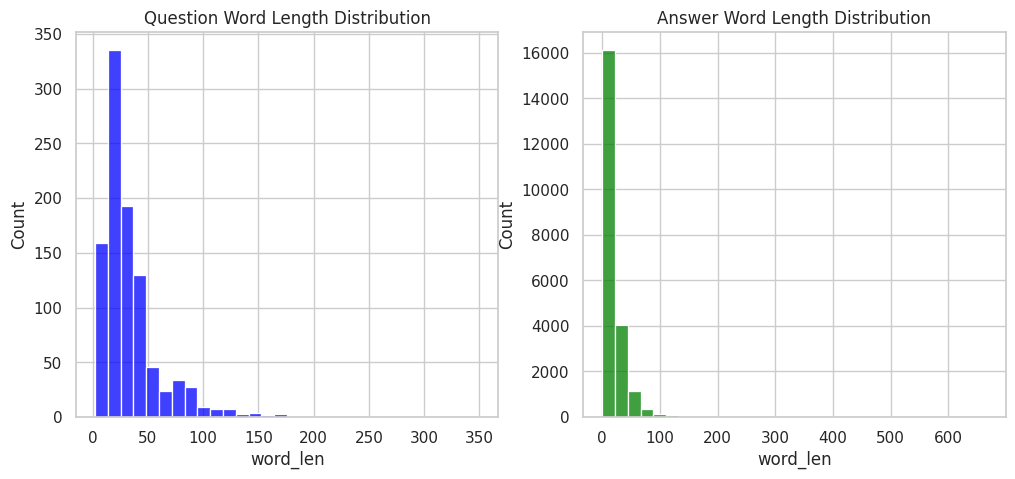

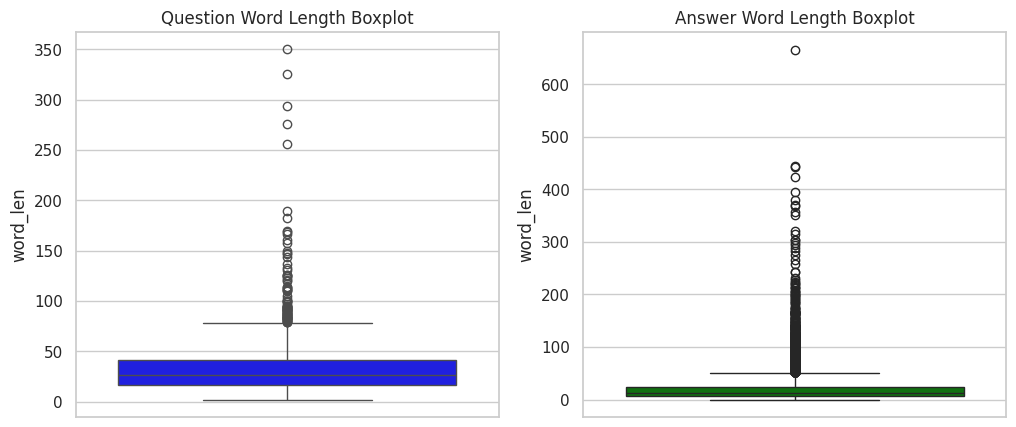

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Histograms
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(questions_df["word_len"], bins=30, color='blue')
plt.title("Question Word Length Distribution")

plt.subplot(1, 2, 2)
sns.histplot(answers_df["word_len"], bins=30, color='green')
plt.title("Answer Word Length Distribution")
plt.show()

# Boxplots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=questions_df["word_len"], color='blue')
plt.title("Question Word Length Boxplot")

plt.subplot(1, 2, 2)
sns.boxplot(y=answers_df["word_len"], color='green')
plt.title("Answer Word Length Boxplot")
plt.show()


## Identify the most engaging questions

In [ ]:
# Count how many answers each question received
answer_counts = answers_df["QID"].value_counts()

questions_df["answer_count"] = questions_df["QID"].map(answer_counts).fillna(0).astype(int)

top_questions = questions_df.sort_values("answer_count", ascending=False).head(10)
top_questions[["QID", "answer_count", "QBody_clean"]]


,QID,answer_count,QBody_clean
571,1556257,315,با تومن چه چیزای از جهاز و میشه خرید که هم اسا...
152,1577970,313,کسی اطلاع داره بخوابم پیش ایشون بریم چطوری و ک...
342,1559359,215,بعد طلاق چطور خودتونو سرپا نگه داشتین چطور خود...
728,1555428,215,من یه سال نامزد کردم قرار یه سال دیگه هم نامزد...
194,1578477,166,بیاین بگین چیکار میکنین نازتونو میکشه من شوهرم...
969,1569562,144,ما عقد هستیم شوهرم اصلا خسیس نیست هر چی بخوام ...
256,1591164,143,شوهرتون ماشین جدید بخره ناراحت میشید به نام شم...
628,1585904,137,استخاره زدم بد اومد ترسیدم واقعا از اینکه الان...
677,1567278,137,سلام دوستان چند روز آینده قراره واسم خواستگار ...
8,1575297,136,شوهرم همش بهانه میگیره همش دعوا میگه توهیچی به...


## Visualize Distribution of Answer Counts

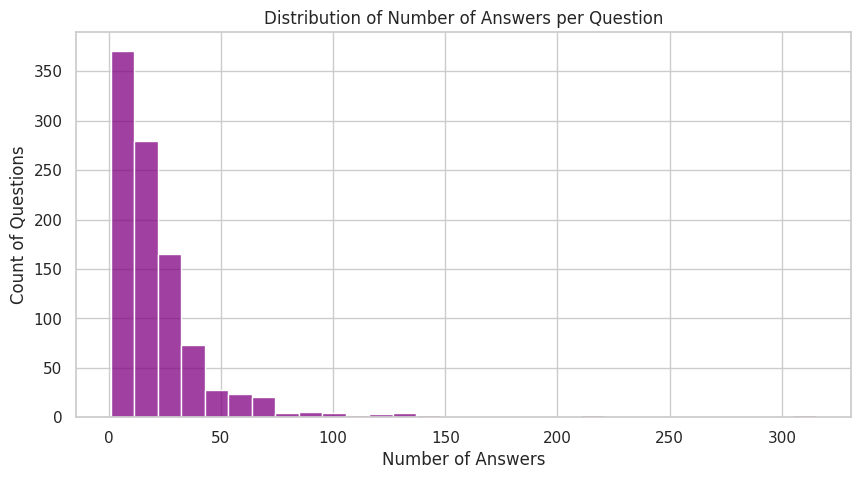

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(questions_df["answer_count"], bins=30, kde=False, color="purple")
plt.title("Distribution of Number of Answers per Question")
plt.xlabel("Number of Answers")
plt.ylabel("Count of Questions")
plt.show()


## Response Rate Analysis

In [ ]:
len(questions_df["QSubject"].unique())

982

In [ ]:
total_questions = len(questions_df)
questions_with_answers = (questions_df["answer_count"] > 0).sum()
response_rate = questions_with_answers / total_questions


print(f"Total Questions: {total_questions}")
print(f"Questions with ≥1 Answer: {questions_with_answers}")
print(f"Response Rate: {response_rate:.2%}")

Total Questions: 990
Questions with ≥1 Answer: 990
Response Rate: 100.00%


## Analyze user activity patterns

### Plot Hourly Activity

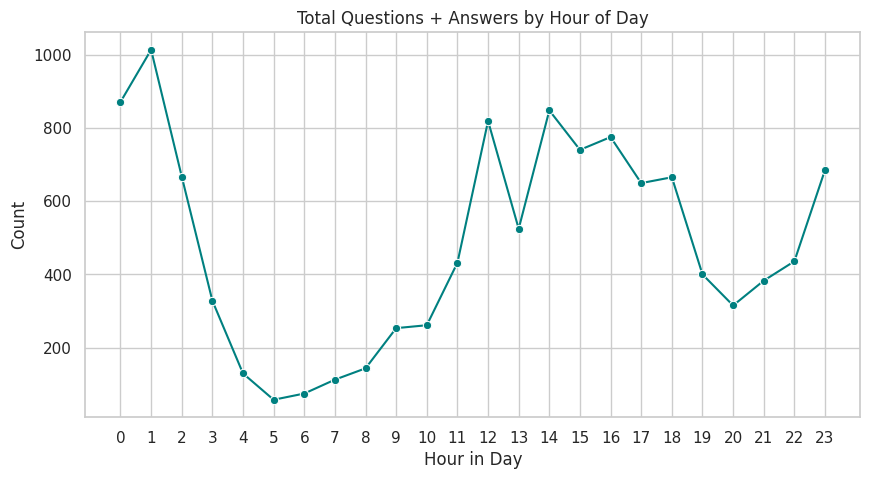

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

answers_df["CDate"] = pd.to_datetime(answers_df["CDate"], errors="coerce")
hourly_as = answers_df["CDate"].dt.hour.value_counts().reindex(range(24), fill_value=0)

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_as.index, y=hourly_as.values, marker="o", color="teal")
plt.title("Total Questions + Answers by Hour of Day")
plt.xlabel("Hour in Day")
plt.ylabel("Count")
plt.xticks(range(24))
plt.grid(True)
plt.show()

### Plot Weekday Activity

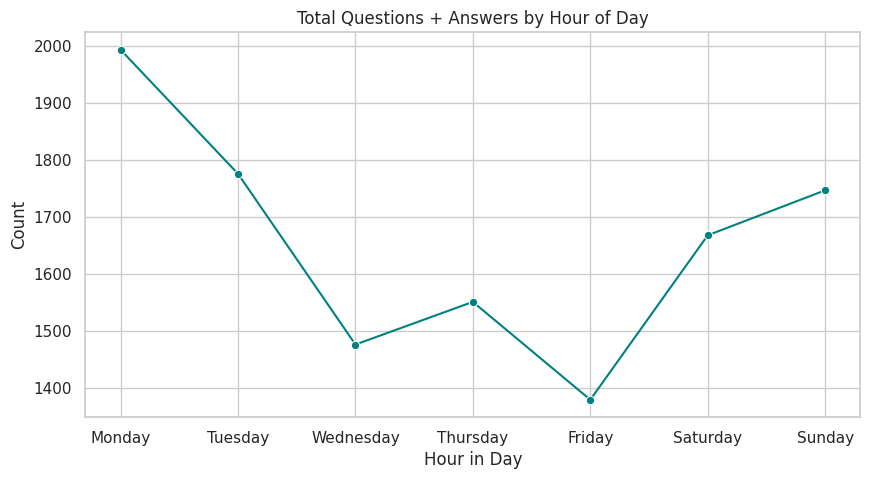

In [ ]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekly_as = answers_df["CDate"].dt.day_name().value_counts().reindex(days_order, fill_value=0)

plt.figure(figsize=(10, 5))
sns.lineplot(x=weekly_as.index, y=weekly_as.values, marker="o", color="teal")
plt.title("Total Questions + Answers by Hour of Day")
plt.xlabel("Hour in Day")
plt.ylabel("Count")
plt.xticks(range(7))
plt.grid(True)
plt.show()

### Heatmap of Answer Activity – Hour vs. Day

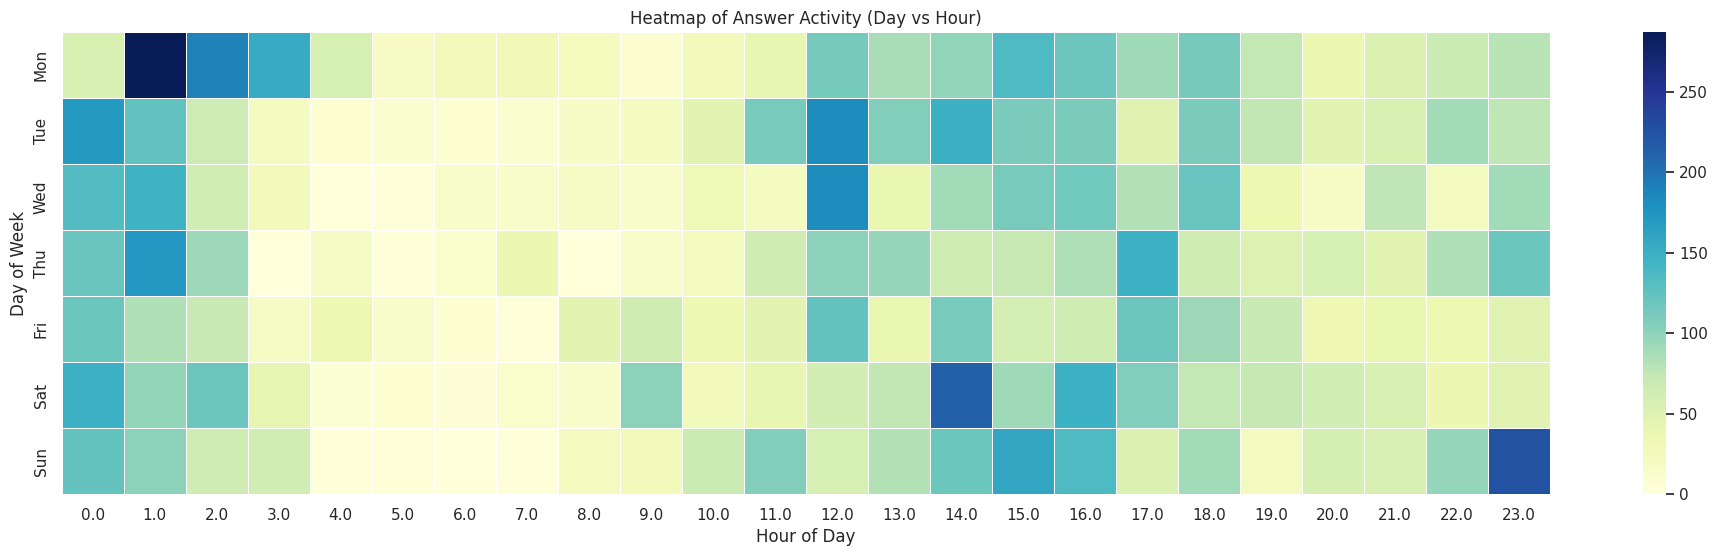

In [ ]:
heatmap_data = answers_df.pivot_table(
    index=answers_df["CDate"].dt.weekday, columns=answers_df["CDate"].dt.hour , values="CBody", aggfunc="count"
).fillna(0)

heatmap_data.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

plt.figure(figsize=(24, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5)
plt.title("Heatmap of Answer Activity (Day vs Hour)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

## Detect top answer contributors

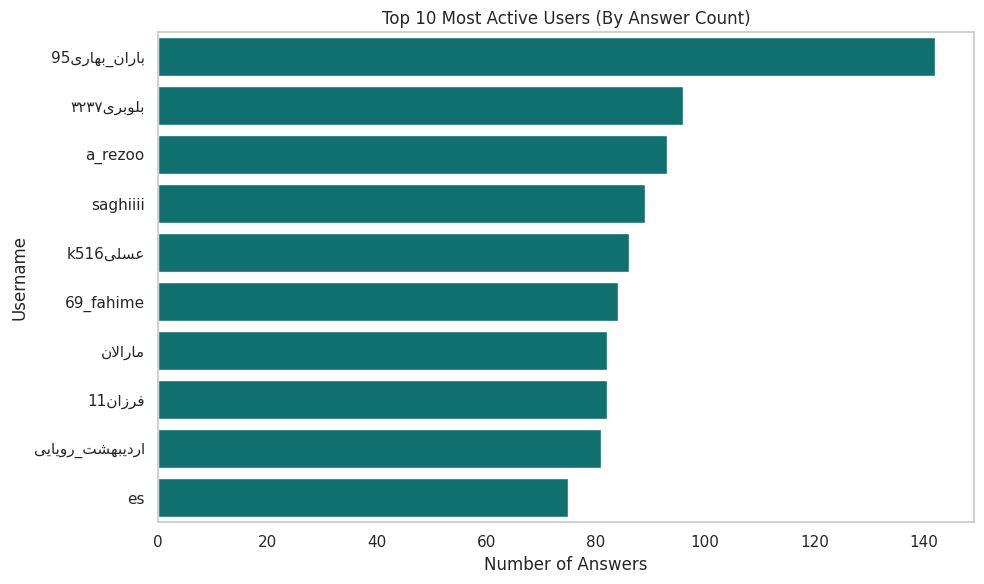

In [ ]:
top_users = answers_df["CUsername"].value_counts().head(10)

top_users.index = top_users.index.map(display_persian)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_users.values, y=top_users.index, color="teal")
plt.title("Top 10 Most Active Users (By Answer Count)")
plt.xlabel("Number of Answers")
plt.ylabel("Username")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

##  Linguistic and Word-Level Analysis (6 pts)

### 1. Most Frequent Words in Questions and Answers
We begin by extracting and visualizing the most frequently used words from both questions and answers.

In [ ]:
tokens_in_answers = []

for tokens in answers_df["CBody_lemmas"]:
    if isinstance(tokens, list):
        tokens_in_answers.extend([token for token in tokens])

tokens_in_questions = []

for tokens in questions_df["QBody_lemmas"]:
    if isinstance(tokens, list):
        tokens_in_questions.extend([token for token in tokens])

tokens_in_answers_display_persian = []

for tokens in answers_df["CBody_lemmas_persian_display"]:
    if isinstance(tokens, list):
        tokens_in_answers_display_persian.extend([token for token in tokens])

tokens_in_questions_display_persian = []

for tokens in questions_df["QBody_lemmas_persian_display"]:
    if isinstance(tokens, list):
        tokens_in_questions_display_persian.extend([token for token in tokens])

print(tokens_in_questions_display_persian[:10], tokens_in_questions[:10])

['ﻥﺎﺘﺳﻭﺩ', 'ﺩﺰﻣﺎﻧ', 'ﺮﻫﻮﺷ', 'ﺎﺑ', 'ﻩﺮﻬﻗ', 'ﺯﻭﺮﻣﺍ', 'ﻪﺷﺪﻟﻮﺗ', 'ﻉﻮﺿﻮﻣ', 'ﻥﻮﻣﺍﻮﻋﺩ', 'ﺮﺼﻘﻣ'] ['دوستان', 'نامزد', 'شوهر', 'با', 'قهره', 'امروز', 'تولدشه', 'موضوع', 'دعوامون', 'مقصر']


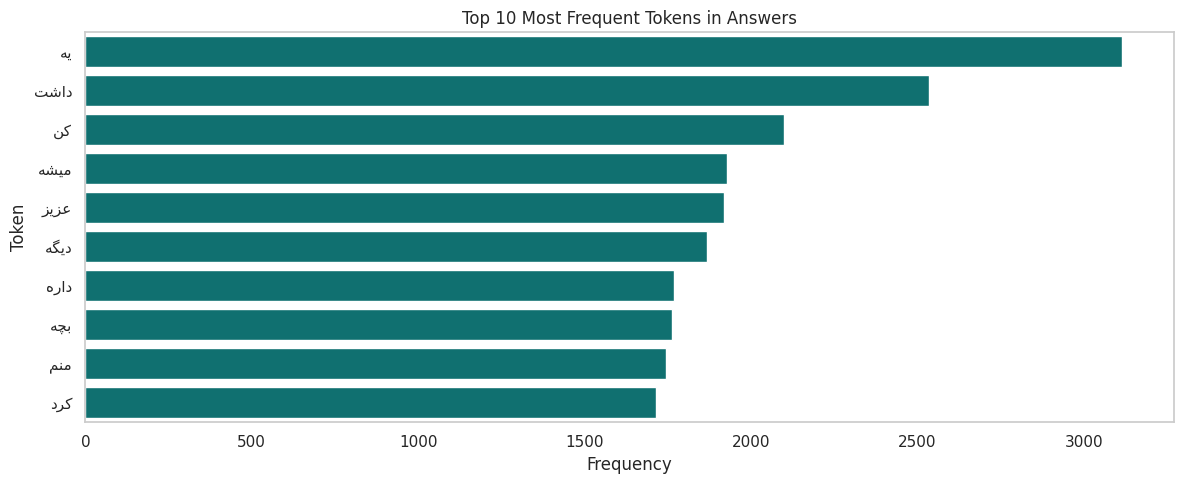

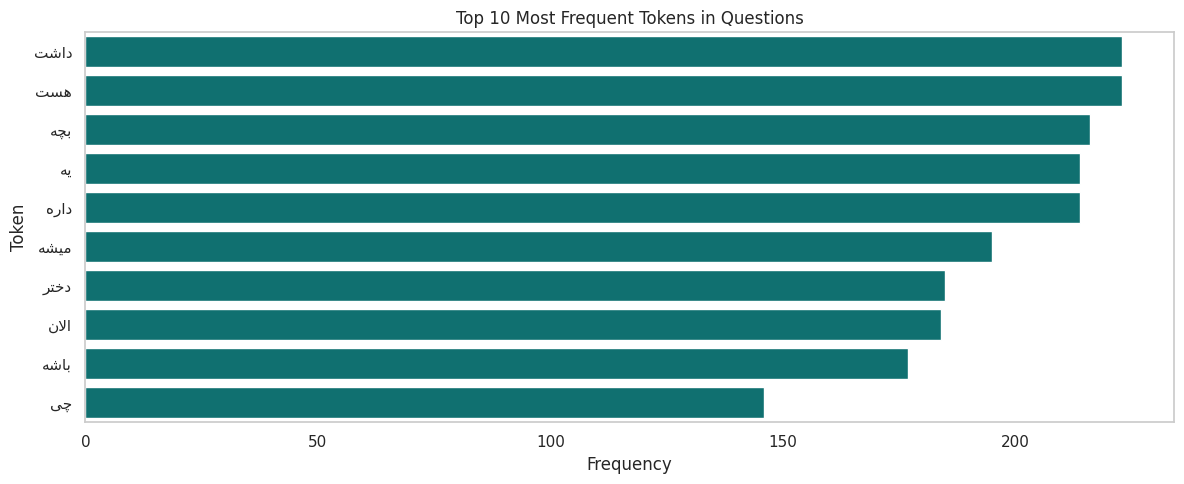

In [ ]:
from collections import Counter

# Count frequencies
answer_counts = Counter(tokens_in_answers_display_persian).most_common(10)
question_counts = Counter(tokens_in_questions_display_persian).most_common(10)

# Convert to DataFrames for plotting
answer_df = pd.DataFrame(answer_counts, columns=["token", "count"])
question_df = pd.DataFrame(question_counts, columns=["token", "count"])

# --- Plot for Answers ---
plt.figure(figsize=(12, 5))
sns.barplot(x="count", y="token", data=answer_df, color="teal")
plt.title("Top 10 Most Frequent Tokens in Answers")
plt.xlabel("Frequency")
plt.ylabel("Token")
plt.grid(axis="x")
plt.tight_layout()
plt.show()

# --- Plot for Questions ---
plt.figure(figsize=(12, 5))
sns.barplot(x="count", y="token", data=question_df, color="teal")
plt.title("Top 10 Most Frequent Tokens in Questions")
plt.xlabel("Frequency")
plt.ylabel("Token")
plt.grid(axis="x")
plt.tight_layout()
plt.show()

### 2. Word Clouds
A WordCloud is a visual representation of text data — it displays words from a body of text where:

More frequent words appear larger and bolder.

Less frequent words appear smaller.

It's often used to capture the main themes or topics in a large collection of text.

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(tokens, title):
    text = " ".join(tokens)

    wordcloud = WordCloud(
        font_path=r"C:\Windows\Fonts\Tahoma.ttf",
        width=800, height=400,
        background_color="white"
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()


generate_wordcloud(tokens_in_questions_display_persian, "WordCloud of Questions")
generate_wordcloud(tokens_in_answers_display_persian, "WordCloud of Answers")

OSError: cannot open resource

### 3. N-gram Analysis
To explore deeper linguistic structures, we analyze unigram (1-word), bigram (2-word), and trigram (3-word) frequencies. We compare these before and after stopword removal to understand how common function words affect patterns.

/tmp/ipython-input-28-2096648705.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="frequency", y="ngram", data=freq_df, palette="magma")


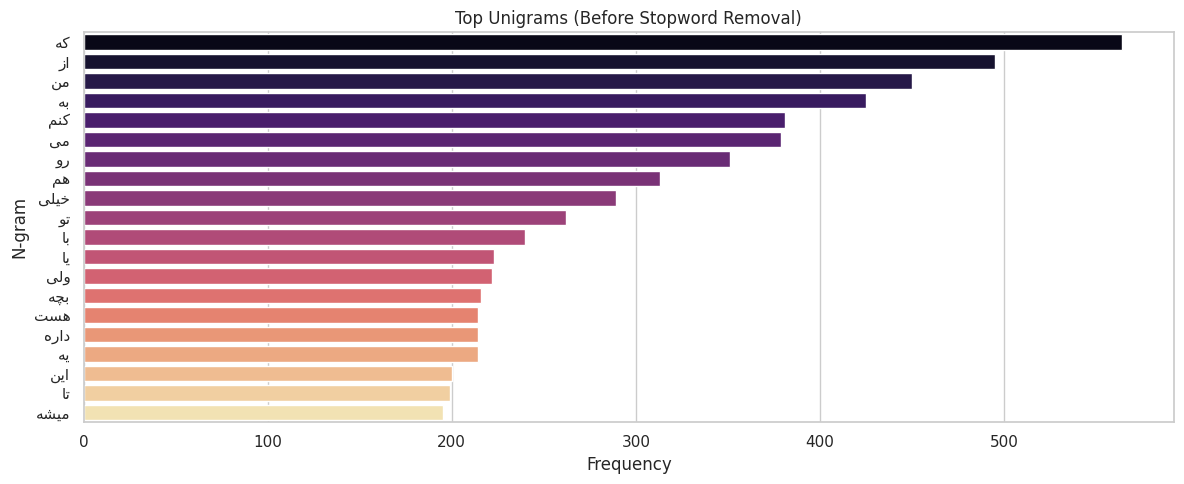

/tmp/ipython-input-28-2096648705.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="frequency", y="ngram", data=freq_df, palette="magma")


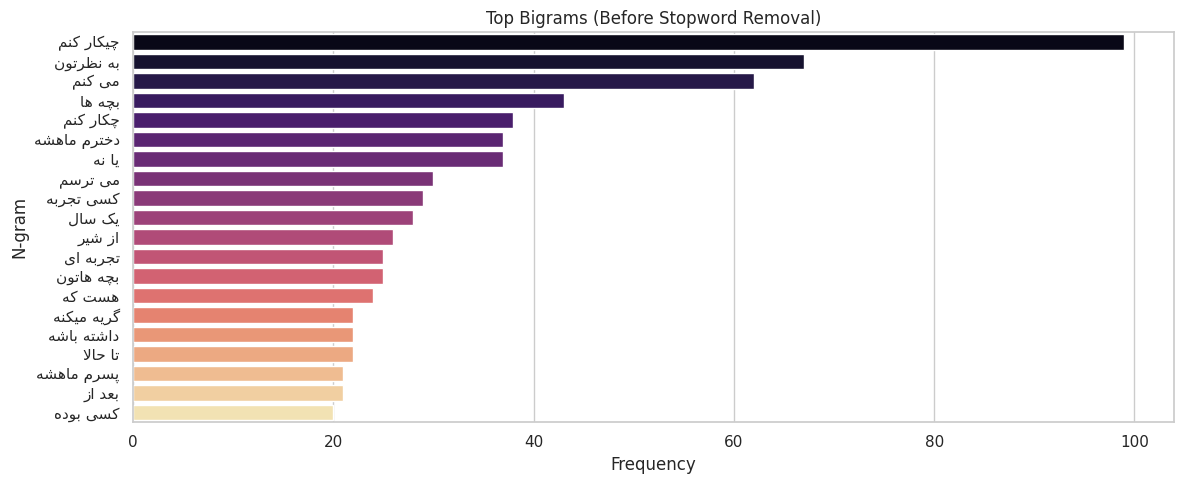

/tmp/ipython-input-28-2096648705.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="frequency", y="ngram", data=freq_df, palette="magma")


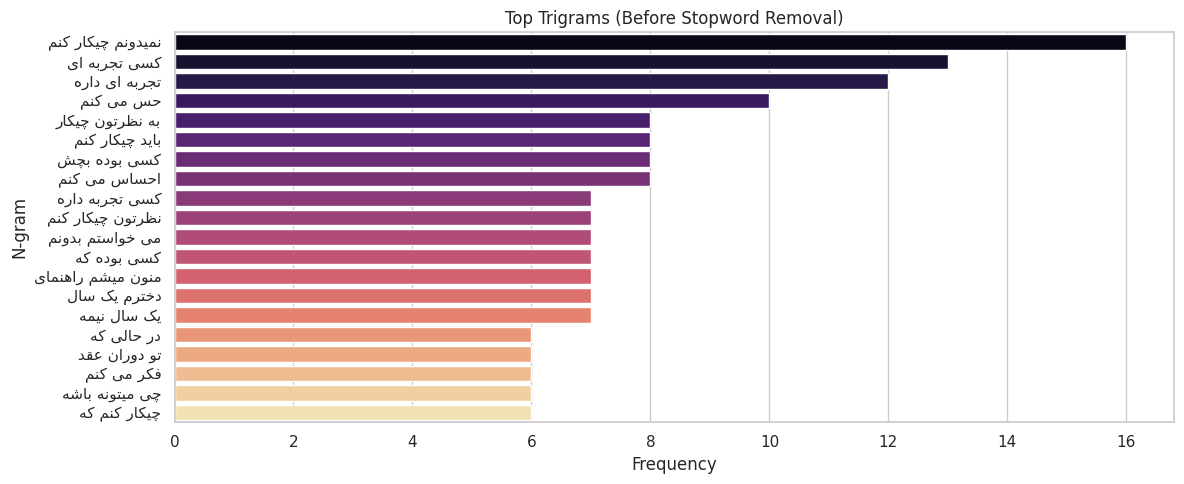

/tmp/ipython-input-28-2096648705.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="frequency", y="ngram", data=freq_df, palette="magma")


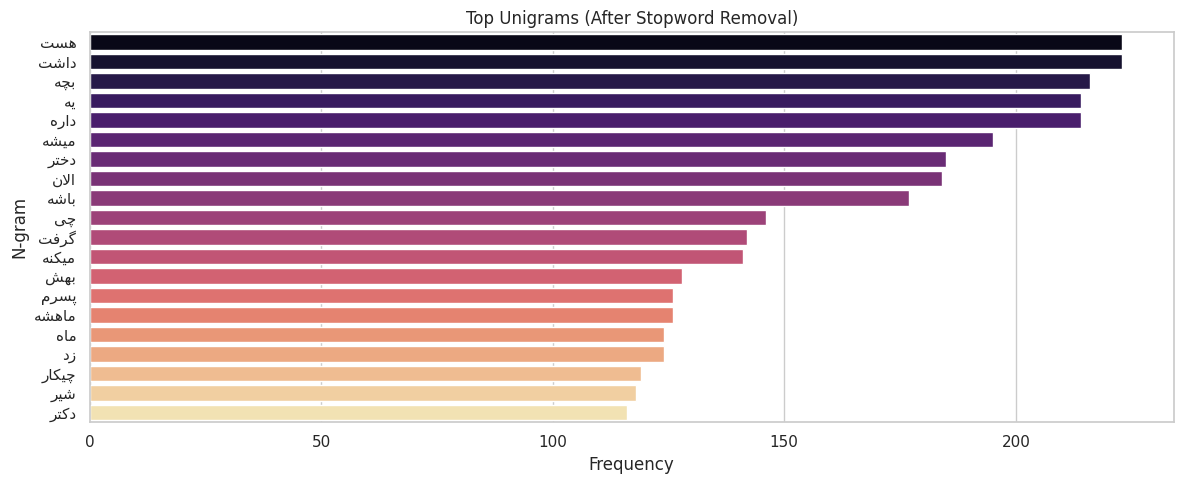

/tmp/ipython-input-28-2096648705.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="frequency", y="ngram", data=freq_df, palette="magma")


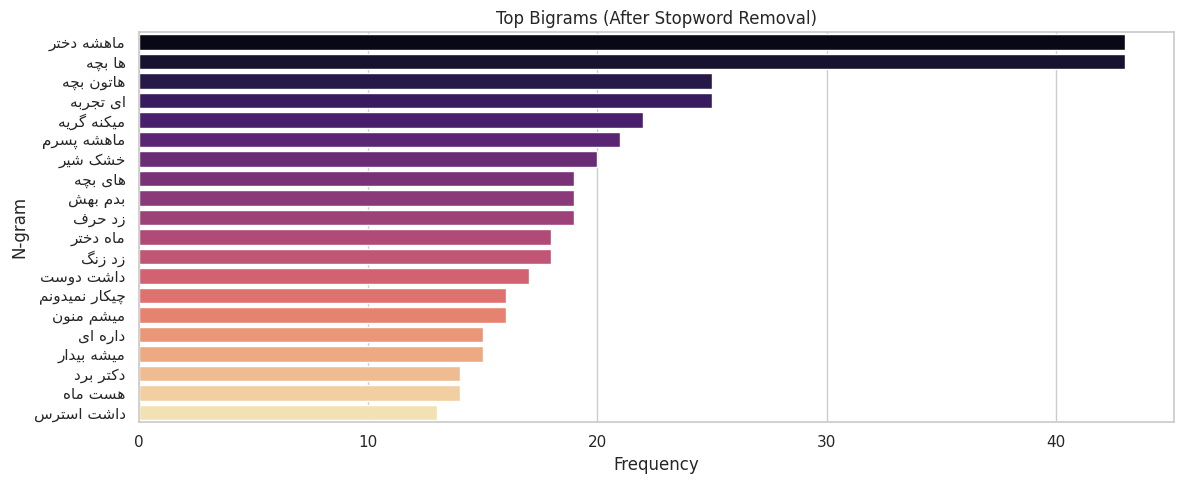

/tmp/ipython-input-28-2096648705.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="frequency", y="ngram", data=freq_df, palette="magma")


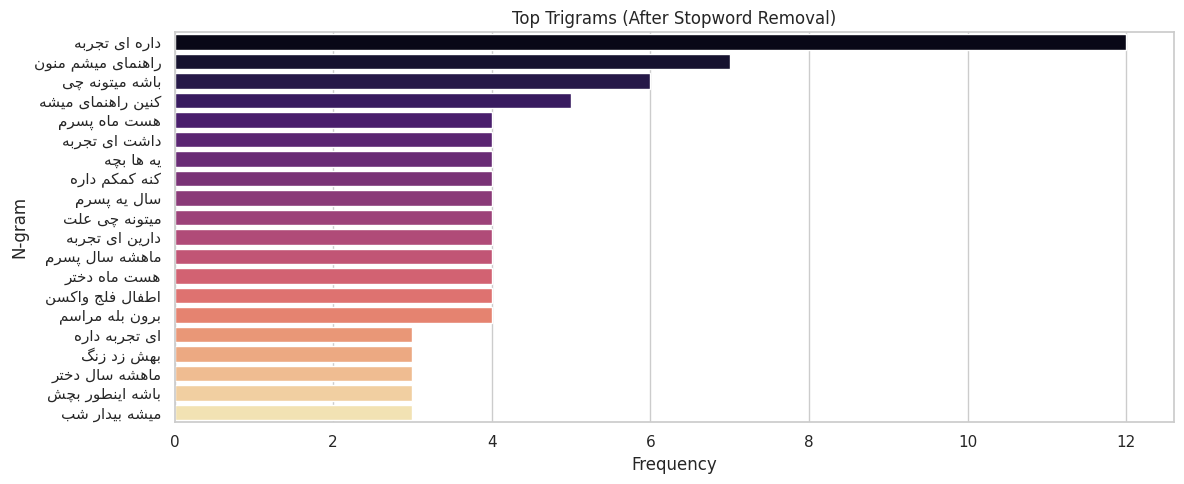

In [ ]:
def plot_ngrams(corpus, ngram_range=(1, 1), title="", top_k=20, stop_words=None):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(corpus)
    ngram_freq = X.sum(axis=0).A1
    ngram_names = vectorizer.get_feature_names_out()

    freq_df = pd.DataFrame({'ngram': ngram_names, 'frequency': ngram_freq})
    freq_df = freq_df.sort_values("frequency", ascending=False).head(top_k)

    plt.figure(figsize=(12, 5))
    sns.barplot(x="frequency", y="ngram", data=freq_df, palette="magma")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("N-gram")
    plt.tight_layout()
    plt.show()

corpus = questions_df["QBody_clean_persian_display"].dropna().astype(str).tolist()

plot_ngrams(corpus, (1, 1), "Top Unigrams (Before Stopword Removal)")
plot_ngrams(corpus, (2, 2), "Top Bigrams (Before Stopword Removal)")
plot_ngrams(corpus, (3, 3), "Top Trigrams (Before Stopword Removal)")

filtered_corpus = [" ".join(tokens) for tokens in questions_df["QBody_lemmas_persian_display"]]

plot_ngrams(filtered_corpus, (1, 1), "Top Unigrams (After Stopword Removal)")
plot_ngrams(filtered_corpus, (2, 2), "Top Bigrams (After Stopword Removal)")
plot_ngrams(filtered_corpus, (3, 3), "Top Trigrams (After Stopword Removal)")

